# Uplift Modeling SOA

In [640]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
from lightgbm import LGBMRegressor


pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [641]:
df = pd.read_csv('Readmit_R.csv')

In [642]:
df.shape

(66782, 11)

In [643]:
# Clean up

df.drop(columns=df.columns[0:1], axis=1, inplace=True)

df.rename({'ID.Codes': 'ID', 
           'Readmission.Status': 'Readmit', 
           'DRG.Class': 'DRG_Class', 
           'DRG.Complication': 'DRG_Comp',
           'HCC.Riskscore': 'HCC'}, axis=1, inplace=True)

In [644]:
df.head()

,ID,Readmit,Gender,Race,ER,DRG_Class,LOS,Age,HCC,DRG_Comp
0,0005EC02F1DC3A15,0,M,White,0,MED,3,71,1.631,MedicalMCC.CC
1,0005EC02F1DC3A15,0,M,White,0,SURG,2,71,1.631,Other
2,0006C4369B0D7B5F,0,M,White,0,MED,2,68,0.585,MedicalNoC
3,000960C9E1C43BE4,0,F,White,0,SURG,12,79,1.660,SurgNoC
4,00098CF15837D918,0,M,White,0,SURG,4,91,1.768,SurgNoC


In [645]:
df.Readmit.value_counts()

0    58373
1     8409
Name: Readmit, dtype: int64

In [646]:
df1 = pd.get_dummies(df, columns = ['Gender','Race','DRG_Class','DRG_Comp'], drop_first=True)

In [647]:
df1.head()

,ID,Readmit,ER,LOS,Age,HCC,Gender_M,Race_Hispanic,Race_Others,Race_White,DRG_Class_SURG,DRG_Class_UNGROUP,DRG_Comp_MedicalNoC,DRG_Comp_Other,DRG_Comp_SurgMCC.CC,DRG_Comp_SurgNoC
0,0005EC02F1DC3A15,0,0,3,71,1.631,1,0,0,1,0,0,0,0,0,0
1,0005EC02F1DC3A15,0,0,2,71,1.631,1,0,0,1,1,0,0,1,0,0
2,0006C4369B0D7B5F,0,0,2,68,0.585,1,0,0,1,0,0,1,0,0,0
3,000960C9E1C43BE4,0,0,12,79,1.660,0,0,0,1,1,0,0,0,0,1
4,00098CF15837D918,0,0,4,91,1.768,1,0,0,1,1,0,0,0,0,1


<Axes: xlabel='Readmit', ylabel='HCC'>

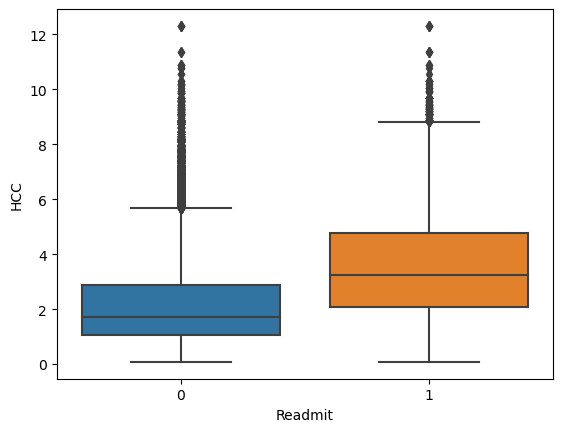

In [648]:
sns.boxplot(x='Readmit', y='HCC',data=df1)

Readmit
0    Axes(0.125,0.11;0.775x0.77)
1    Axes(0.125,0.11;0.775x0.77)
Name: HCC, dtype: object

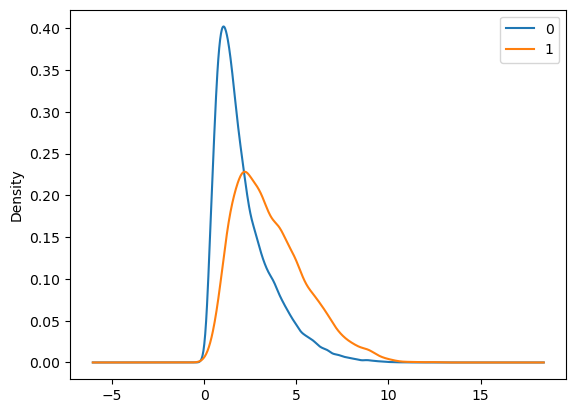

In [649]:
df1.groupby('Readmit')['HCC'].plot(kind='density', legend=True)

## Model Propensities 

In [650]:
model = LogisticRegression()
#model = DecisionTreeClassifier()

In [651]:
df_X = df1.drop(['Readmit','ID'],axis=1)
df_y = df1['Readmit']

In [652]:
model.fit(df_X, df_y)

/Users/joehaber/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [653]:
y_pred = model.predict_proba(df_X)[:,1]

In [654]:
y_pred1 = model.predict(df_X)
#y_pred1 = (model.predict_proba(df_X)[:,1] >= 0.11)#.astype(bool) 

In [655]:
df1['preds'] = y_pred
df1['preds1'] = y_pred1

In [656]:
df1.head()

,ID,Readmit,ER,LOS,Age,HCC,Gender_M,Race_Hispanic,Race_Others,Race_White,DRG_Class_SURG,DRG_Class_UNGROUP,DRG_Comp_MedicalNoC,DRG_Comp_Other,DRG_Comp_SurgMCC.CC,DRG_Comp_SurgNoC,preds,preds1
0,0005EC02F1DC3A15,0,0,3,71,1.631,1,0,0,1,0,0,0,0,0,0,0.078859,0
1,0005EC02F1DC3A15,0,0,2,71,1.631,1,0,0,1,1,0,0,1,0,0,0.088873,0
2,0006C4369B0D7B5F,0,0,2,68,0.585,1,0,0,1,0,0,1,0,0,0,0.052369,0
3,000960C9E1C43BE4,0,0,12,79,1.660,0,0,0,1,1,0,0,0,0,1,0.082954,0
4,00098CF15837D918,0,0,4,91,1.768,1,0,0,1,1,0,0,0,0,1,0.076201,0


array([[<Axes: title={'center': 'preds'}>]], dtype=object)

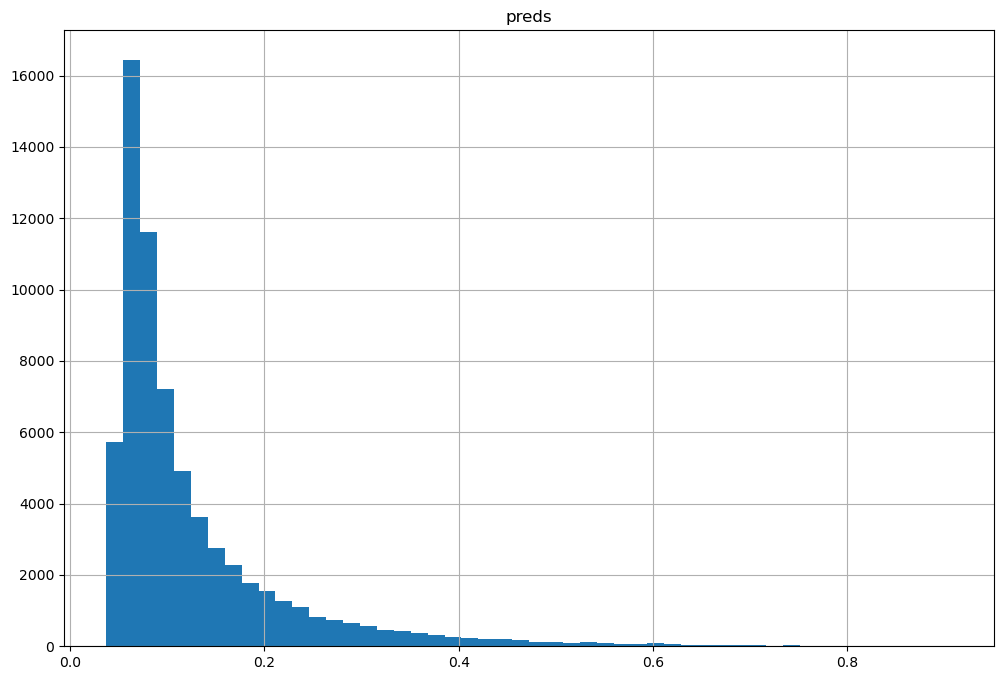

In [657]:
df1.hist(column ='preds', bins=50, grid=True, figsize=(12, 8))

In [749]:
#pd.qcut(df1.preds, 5)

mask = (df1.preds >= df1.preds.quantile(0.6)) & (df1.preds <= df1.preds.quantile(0.8))
df1['subgroup'] = np.where((df1.preds >= df1.preds.quantile(0.6))&(df1.preds <= df1.preds.quantile(0.8)),1,0)
df1.head()

,ID,Readmit,ER,LOS,Age,HCC,Gender_M,Race_Hispanic,Race_Others,Race_White,DRG_Class_SURG,DRG_Class_UNGROUP,DRG_Comp_MedicalNoC,DRG_Comp_Other,DRG_Comp_SurgMCC.CC,DRG_Comp_SurgNoC,preds,preds1,Tx,Readmit1,subgroup
0,0005EC02F1DC3A15,0,0,3,71,1.631,1,0,0,1,0,0,0,0,0,0,0.078859,0,0,0,0
1,0005EC02F1DC3A15,0,0,2,71,1.631,1,0,0,1,1,0,0,1,0,0,0.088873,0,0,0,0
2,0006C4369B0D7B5F,0,0,2,68,0.585,1,0,0,1,0,0,1,0,0,0,0.052369,0,0,0,0
3,000960C9E1C43BE4,0,0,12,79,1.660,0,0,0,1,1,0,0,0,0,1,0.082954,0,0,0,0
4,00098CF15837D918,0,0,4,91,1.768,1,0,0,1,1,0,0,0,0,1,0.076201,0,0,0,0


In [659]:
pd.crosstab(df1['Readmit'],df1['preds1'])

preds1,0,1
Readmit,,
0,57878,495
1,8006,403


<Axes: xlabel='HCC', ylabel='preds'>

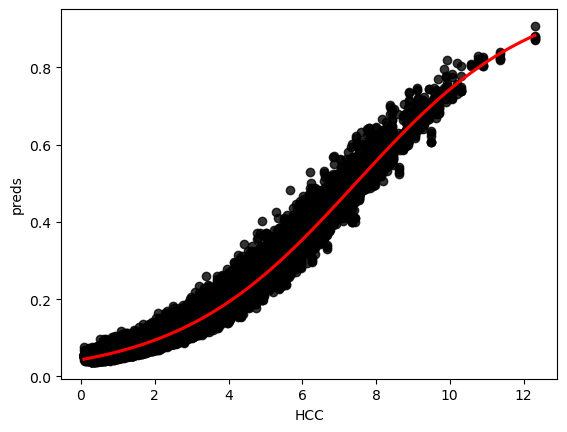

In [660]:
#df1['preds'].plot(kind='density', legend=True)
sns.regplot(x='HCC', y='preds', data=df1, logistic=True, ci=None,
           scatter_kws={'color': 'black'}, line_kws={'color': 'red'})

<Axes: xlabel='Readmit', ylabel='preds'>

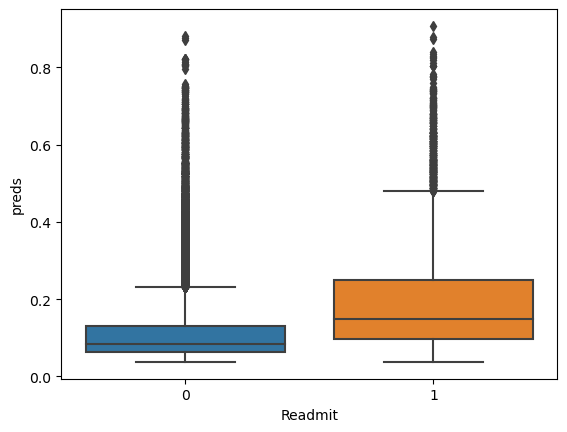

In [661]:
sns.boxplot(x='Readmit', y='preds',data=df1)

<Axes: xlabel='preds1', ylabel='HCC'>

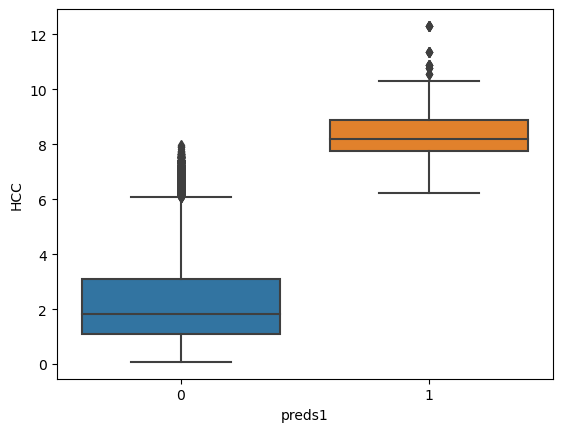

In [662]:
sns.boxplot(x='preds1', y='HCC',data=df1)

## Create Treatment 

In [663]:
# generate random floating point values
from random import seed
from random import random
# seed random number generator
seed(1)

# Randomized Tx (20% of cohort)
df1['Tx'] = [1 if np.random.rand()<0.2 else 0 for k in df1.index]

In [750]:
# Tx Effect 

p = .4
p1=.85
q = .5

# Define a lambda function to apply to each row of the DataFrame
def generate_binary(row):
    if row['Tx']*row['Readmit'] == 1:
        if row['preds']==1:
            return 1 - int(np.random.rand() < p1*q)
        else:
            return 1 - int(np.random.rand() < p*q)
    else:
        return row['Readmit']

# Apply the lambda function to each row of the DataFrame to create a new column called 'binary_col'
# Readmit1 after Tx impact
df1['Readmit1'] = df1.apply(lambda row: generate_binary(row), axis=1)

In [754]:
df1['Readmit'].value_counts()
pd.crosstab(df1['Readmit'],df1['Tx'])

Tx,0,1
Readmit,,
0,46926,11447
1,6812,1597


In [755]:
pd.crosstab(df1['Readmit1'],df1['Tx'])

Tx,0,1
Readmit1,,
0,46926,11765
1,6812,1279


## Uplift Model

### 1. Constant Tx (ATE)

In [756]:
df1.groupby('Tx')['Readmit'].mean()

Tx
0    0.126763
1    0.122432
Name: Readmit, dtype: float64

In [757]:
df1.groupby('Tx')['Readmit1'].mean()
# diff impact = .024 (.12 readmits * .2 impact)

Tx
0    0.126763
1    0.098053
Name: Readmit1, dtype: float64

In [758]:
.12*.65*.5

0.039

In [777]:
features = df1.drop(['Readmit','Readmit1','ID','preds','preds1'],axis=1)
y = df1[['Readmit','Readmit1','subgroup']]

In [778]:
from sklearn.model_selection import train_test_split

#train, test = train_test_split(df1, test_size=0.3)
x_train, x_test, y_train1, y_test1 = train_test_split(features, y, test_size=0.3, random_state=0)

In [779]:
y_train=y_train1.drop(['Readmit','subgroup'],axis=1)
y_test=y_test1.drop(['Readmit','subgroup'],axis=1)

In [780]:
# Initiate the light GBM model
s_learner = LGBMRegressor()
# Fit the model
s_learner.fit(x_train, y_train);

In [781]:
# Set treatment value to 1
with_treatment = x_test.assign(Tx = 1)
# With treatment predictions
with_treatment_predict = s_learner.predict(with_treatment)
# Set treatment value to 0
without_treatment = x_test.assign(Tx = 0)
# With treatment predictions
without_treatment_predict = s_learner.predict(without_treatment)

In [782]:
x_train1 = x_train.drop(['Tx'],axis=1)
x_test1 = x_test.drop(['Tx'],axis=1)

In [783]:
x_train1.head()

,ER,LOS,Age,HCC,Gender_M,Race_Hispanic,Race_Others,Race_White,DRG_Class_SURG,DRG_Class_UNGROUP,DRG_Comp_MedicalNoC,DRG_Comp_Other,DRG_Comp_SurgMCC.CC,DRG_Comp_SurgNoC,subgroup
32380,0,6,73,2.392,0,0,0,1,1,0,0,0,0,1,1
31166,1,6,70,1.038,0,0,1,0,1,0,0,0,1,0,0
10877,1,4,77,0.552,0,0,0,0,1,0,0,0,1,0,0
10322,0,1,85,1.018,1,0,0,1,1,0,0,0,1,0,0
22199,0,4,82,2.369,1,0,0,1,1,0,0,0,1,0,0


In [784]:
# Initiate the light GBM model
s_learner1 = LGBMRegressor()
# Fit the model
s_learner1.fit(x_train1, y_train);

In [785]:
preds = s_learner1.predict(x_test1)

In [786]:
x_test.shape

(20035, 16)

In [792]:
# ITE
ite = with_treatment_predict - without_treatment_predict
# Save ITE data in a pandas dataframe
ite_df = pd.DataFrame({'ITE': ite, 'with_treatment_predict':with_treatment_predict, 
                       'without_treatment_predict': without_treatment_predict,
                       'pred':preds,
                       'Readmit':y_test1.Readmit,
                       'Readmit1':y_test1.Readmit1,
                       'Tx':x_test.Tx,
                       'Subgroup':y_test1.subgroup})
# Take a look at the data
ite_df.sort_values(by='pred',ascending=False).head(10)

,ITE,with_treatment_predict,without_treatment_predict,pred,Readmit,Readmit1,Tx,Subgroup
24869,0.017350,0.725859,0.708509,0.793091,0,0,0,0
9741,-0.026666,0.751205,0.777871,0.771320,1,1,0,0
65439,-0.033334,0.695267,0.728601,0.769929,1,1,1,0
34329,-0.094707,0.641852,0.736560,0.743597,1,1,0,0
902,-0.021061,0.639033,0.660094,0.739030,1,1,0,0
54995,-0.038051,0.610687,0.648738,0.717417,1,1,0,0
54112,-0.038147,0.602990,0.641137,0.712228,0,0,0,0
25218,-0.097465,0.579939,0.677405,0.710470,0,0,0,0
23770,-0.016044,0.659056,0.675100,0.689294,1,1,0,0
17958,-0.150547,0.471582,0.622129,0.673568,0,0,0,0


In [805]:
# Preds 
ite_df['pred_bin'] = pd.qcut(ite_df.pred, 10)

# ITE
ite_df['pred_bin'] = pd.qcut(ite_df.ITE, 10)

In [806]:
ite_df.head()

,ITE,with_treatment_predict,without_treatment_predict,pred,Readmit,Readmit1,Tx,Subgroup,pred_bin
66684,-0.057690,0.124563,0.182254,0.178197,0,0,0,1,"(-0.0626, -0.0472]"
6856,-0.029151,0.095181,0.124333,0.123880,0,0,0,0,"(-0.0355, -0.0251]"
32334,-0.042532,0.094274,0.136807,0.128631,0,0,0,1,"(-0.0472, -0.0355]"
56214,-0.010244,0.056705,0.066949,0.066528,0,0,1,0,"(-0.011, -0.00853]"
39403,-0.038631,0.197560,0.236191,0.245601,1,1,0,0,"(-0.0472, -0.0355]"


In [807]:
#ite_df[ite_df.ITE>0].sort_values(by='pred',ascending=False).head()

In [808]:
df = ite_df.groupby('pred_bin').agg({'pred':'mean','ITE':'mean','Readmit':'mean','Readmit1':'mean','Subgroup':'sum'}).reset_index()
df['diff'] = df.Readmit - df.Readmit1
df

,pred_bin,pred,ITE,Readmit,Readmit1,Subgroup,diff
0,"(-0.374, -0.0626]",0.261517,-0.095320,0.280439,0.271457,307,0.008982
1,"(-0.0626, -0.0472]",0.197057,-0.054023,0.197211,0.190239,1248,0.006972
2,"(-0.0472, -0.0355]",0.157181,-0.040362,0.174447,0.165111,1127,0.009337
3,"(-0.0355, -0.0251]",0.143483,-0.030001,0.159126,0.150991,590,0.008134
4,"(-0.0251, -0.0149]",0.102667,-0.017921,0.101679,0.098321,237,0.003357
5,"(-0.0149, -0.011]",0.074351,-0.012855,0.073960,0.069851,73,0.004109
6,"(-0.011, -0.00853]",0.053391,-0.009860,0.049058,0.047572,44,0.001487
7,"(-0.00853, -0.00574]",0.041122,-0.007393,0.037487,0.036981,49,0.000507
8,"(-0.00574, -0.00113]",0.037535,-0.004076,0.036628,0.036126,56,0.000502
9,"(-0.00113, 0.177]",0.141593,0.020482,0.134232,0.128743,247,0.005489


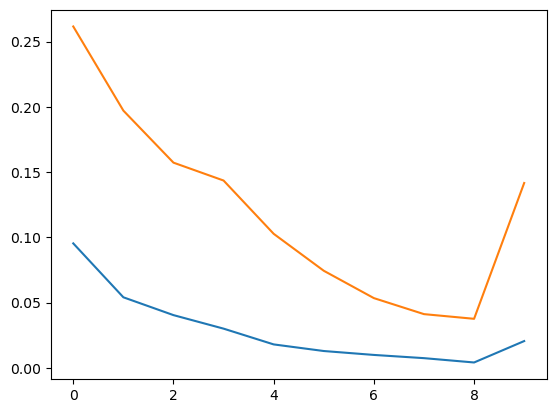

In [800]:
#df.plot(x='pred_bin', y=['pred','-ITE'])
plt.plot(df['ITE'].apply(lambda x: x if x > 0 else -x))
plt.plot(df['pred'])
plt.show()

array([[<Axes: title={'center': 'ITE'}>]], dtype=object)

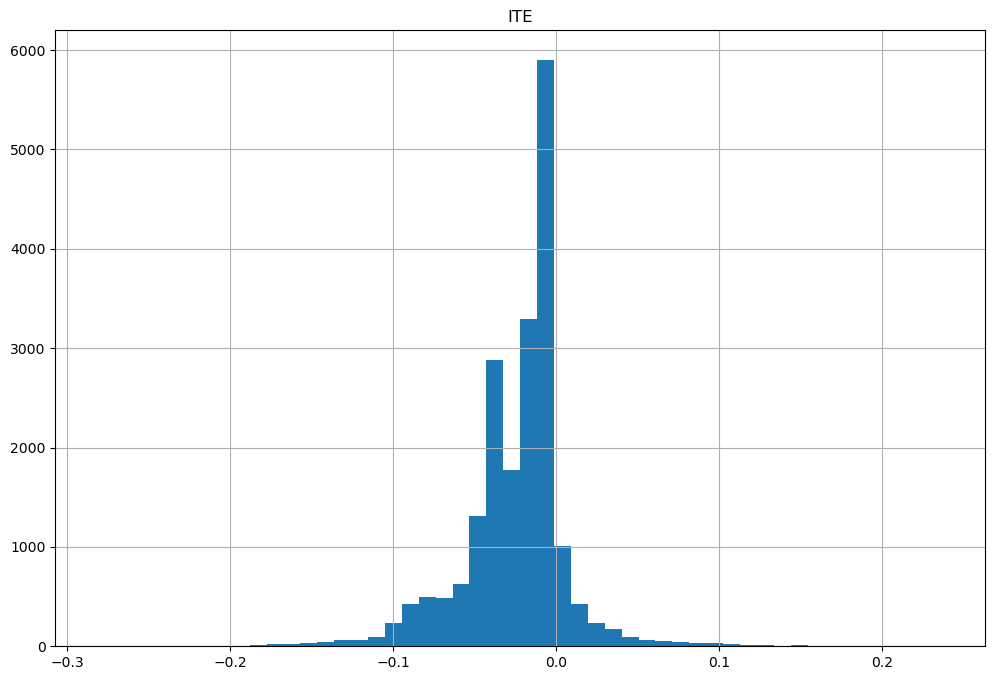

In [722]:
# visualization
ite_df.hist(column ='ITE', bins=50, grid=True, figsize=(12, 8))

In [723]:
# Calculate ATE
ATE = ite.mean()
ATE

-0.02384988795584058

### 2. based on propensity/HCC (CATE)